In [57]:
%matplotlib inline
import numpy as np
import torch
import sys
sys.path.append('../')
from voting_games.werewolf_env_v0 import plurality_env, Roles, Phase
from notebooks.learning_agents.models import ActorCriticAgent
from notebooks.learning_agents.utils import play_static_game, play_recurrent_game
from notebooks.learning_agents.static_agents import (
    random_plurality_villager, 
    random_coordinated_plurality_villager, 
    random_agent,
    random_plurality_wolf,
    revenge_plurality_wolf,
    coordinated_revenge_plurality_wolf)
import notebooks.learning_agents.stats as indicators
import random
import copy
from matplotlib import pyplot as plt
from tqdm import tqdm
from tabulate import tabulate

# Plurality Voting

Plurality is a voting method where each voter picks a single candidate, and the candidate with the most votes is selected. It's simplicity has lead to wide adoption, however there are quite a few drawbacks, one of which being the limited expressibility of a voter.

In our Werewolf plurality implementation, an agent can only select a single target, and cannot express their beliefs towards the remaining agents. This is also the voting mechanism used in every paper involving the Werewolf game up to now, so we want to see how our trained agents compare.


## Win Rates

We want to see how our hand-crafted agents play against eachother, with special interest given to coordinated random villagers and wolves. 

As expected, the coordinated random villagers and wolves performed the best out of the static policies {cite}`braverman2008mafia`.
Our agent, trained against coordinated random wolves, performed better than all of our hand-crafted villager policies. They also generalized well against our other wolf policies, and actually had the highest win rates across the board.

Below is code to generate the following table of 1000 runs between each villager policy and each werewolf policy. We base our discussion around this markdown table.

```{warning}
Our trained agent, Trained-CRWolves, is an outlier that got above a $0.40$ win-rate. On average, trained plurality agents did not do as well.
```
Villager Strategy vs. | [Random](rwolves) | [CRWolves](crwolves) | [RevWolves](revwolves) | [CRevWolves](crevwolves)
| --- | --- | --- | --- | --- | 
[Random](r-villagers) | 0.597 | 0.042 | 0.076 | 0.074 |
[L-Targets](l-villagers) | 0.705 | 0.125 | 0.192 | 0.244 |
[CL-Targets](cl-villagers) | 0.653 | 0.314 | 0.304 | 0.281 |
[Trained-CRWolves](trained-villagers) | **0.83** | **0.473** | **0.45** | **0.503** |

In [2]:
env = plurality_env(num_agents=10, werewolves=2, num_accusations=2)
observations, _, _, _, _ = env.reset()

obs_size= env.convert_obs(observations['player_0']['observation']).shape[-1]

trained_plurality_agent = ActorCriticAgent({"rec_hidden_size": 128,
                                        "rec_layers": 1, 
                                        "joint_mlp_size": 128,
                                        "split_mlp_size": 128,
                                        "num_votes": 1,
                                        "approval_states": 10},
                                        num_players=10,
                                        obs_size=obs_size)
trained_plurality_agent.load_state_dict(torch.load("../notebooks/stored_agents/lstm_first_no_one_hot_128_128/plurality_agent_10_score_46"))

num_games = 1000
print(f'10 players, with 2 wolves - number of games played : {num_games} \n')

rv_wins = []
rv_replays = []
for wolf_policy in [random_agent, random_plurality_wolf, revenge_plurality_wolf, coordinated_revenge_plurality_wolf]:
    wins, replays = play_static_game(env, wolf_policy, random_agent, num_times=num_games)
    rv_wins.append(wins/float(num_games))
    rv_replays.append(replays)

rpv_wins = []
rpv_replays = []
for wolf_policy in [random_agent, random_plurality_wolf, revenge_plurality_wolf, coordinated_revenge_plurality_wolf]:
    wins, replays = play_static_game(env, wolf_policy, random_plurality_villager, num_times=num_games)
    rpv_wins.append(wins/float(num_games))
    rpv_replays.append(replays)

cpv_wins = []
cpv_replays = []
for wolf_policy in [random_agent, random_plurality_wolf, revenge_plurality_wolf, coordinated_revenge_plurality_wolf]:
    wins, replays = play_static_game(env, wolf_policy, random_coordinated_plurality_villager, num_times=num_games)
    cpv_wins.append(wins/float(num_games))
    cpv_replays.append(replays)

tpv_wins = []
tpv_replays = []
for wolf_policy in [random_agent, random_plurality_wolf, revenge_plurality_wolf, coordinated_revenge_plurality_wolf]:
    # wins, replays = play_static_game(env, wolf_policy, random_agent, num_times=num_games)[0]/float(num_games)
    wins, replays = play_recurrent_game(env, wolf_policy, trained_plurality_agent, num_times=num_games, hidden_state_size=128, voting_type="plurality")
    tpv_wins.append(wins/float(num_games))
    tpv_replays.append(replays)

print(tabulate([['Random', *rv_wins], 
                ['L-Targets', *rpv_wins], 
                ['CL-Targets', *cpv_wins], 
                ['Trained-CRWolves', *tpv_wins]], 
               headers=["Villager Strategy vs", 
                        "Random", 
                        "CRWolves", 
                        "RevWolves",
                        "CRevWolves"]))

10 players, with 2 wolves - number of games played : 1000 

Villager Strategy vs      Random    CRWolves    RevWolves    CRevWolves
----------------------  --------  ----------  -----------  ------------
Random                     0.594       0.044        0.076         0.033
L-Targets                  0.674       0.123        0.18          0.109
CL-Targets                 0.653       0.324        0.297         0.309
Trained-CRWolves           0.843       0.475        0.428         0.444


In [3]:
tpv_win_replays = [[r for r in replay if r[-1]["winners"] == Roles.VILLAGER] for replay in tpv_replays]
rv_win_replays = [[r for r in replay if r[-1]["winners"] == Roles.VILLAGER] for replay in rv_replays]
rpv_win_replays = [[r for r in replay if r[-1]["winners"] == Roles.VILLAGER] for replay in rpv_replays]
cpv_win_replays = [[r for r in replay if r[-1]["winners"] == Roles.VILLAGER] for replay in cpv_replays]

### Days elapsed before a villager win

In [4]:
rv_days = [np.mean([villager_win[-1]["day"] for villager_win in replays]) for replays in rv_win_replays]
rpv_days = [np.mean([villager_win[-1]["day"] for villager_win in replays]) for replays in rpv_win_replays]
cpv_days = [np.mean([villager_win[-1]["day"] for villager_win in replays]) for replays in cpv_win_replays]
tpv_days = [np.mean([villager_win[-1]["day"] for villager_win in replays]) for replays in tpv_win_replays]

print(tabulate([['Random', *rv_days], 
                ['L-Targets', *rpv_days], 
                ['CL-Targets', *cpv_days], 
                ['Trained-CRWolves', *tpv_days]], 
               headers=["Villager Strategy vs", 
                        "Random", 
                        "CRWolves", 
                        "RevWolves",
                        "CRevWolves"]))

Villager Strategy vs      Random    CRWolves    RevWolves    CRevWolves
----------------------  --------  ----------  -----------  ------------
Random                   3.1835      3.15909      3.40789       3.30303
L-Targets                3.11424     3.52846      3.53333       3.47706
CL-Targets               3.17764     3.52778      3.50168       3.51133
Trained-CRWolves         2.77699     2.92421      3.06542       2.7973


We had mentioned that this days elapsed indicator is a quick litmus test for any learned improvements, and we can see that the trained agent is quicker on average across the board.

### Days between wolf executions

In [5]:
tpv_exec = [np.mean([b-a for a,b in [indicators._when_did_wolves_get_killed(vwin) for vwin in replays]]) for replays in tpv_win_replays[1:]]
rv_exec = [np.mean([b-a for a,b in [indicators._when_did_wolves_get_killed(vwin) for vwin in replays]]) for replays in rv_win_replays[1:]]
rpv_exec = [np.mean([b-a for a,b in [indicators._when_did_wolves_get_killed(vwin) for vwin in replays]]) for replays in rpv_win_replays[1:]]
cpv_exec = [np.mean([b-a for a,b in [indicators._when_did_wolves_get_killed(vwin) for vwin in replays]]) for replays in cpv_win_replays[1:]]

print(tabulate([['Random', *rv_exec], 
                ['L-Targets', *rpv_exec], 
                ['CL-Targets', *cpv_exec], 
                ['Trained-CRWolves', *tpv_exec]], 
               headers=["Villager Strategy vs", 
                        "CRWolves", 
                        "RevWolves",
                        "CRevWolves"]))

Villager Strategy vs      CRWolves    RevWolves    CRevWolves
----------------------  ----------  -----------  ------------
Random                     1.59091      1.72368       1.66667
L-Targets                  1.72358      1.74444       1.78899
CL-Targets                 1.69136      1.67677       1.59223
Trained-CRWolves           1.56842      1.60748       1.49099


This number is one we also expected to be lower, but it won't be as drastic in a 10 player game due to the shortness of games. At most we have $5$ days. Regardless, a lower number means the agents are better at identifying duplicitous werewolf players. We can see our trained villagers have a lower day between wolf executions across the board.

### Ties

In [6]:
tie_info = [np.nanmean(np.stack([indicators._process_tie_info(indicators._game_tie_info(replay, voting_type="plurality")) for replay in replays]), axis=0) for replays in tpv_win_replays[1:]]

print(tabulate([['vs. CRWolves', *tie_info[0]], 
                ['vs. RevWolves', *tie_info[1]], 
                ['vs. CRevWolves', *tie_info[2]]], 
               headers=["Trained-CRWolves", 
                        "Tie in Accusation", 
                        "Tie in Voting",
                        "Tie in Voting given a tie in accusation",
                        "Likelihood of wolf targetted after a tie"]))



Trained-CRWolves      Tie in Accusation    Tie in Voting    Tie in Voting given a tie in accusation    Likelihood of wolf targetted after a tie
------------------  -------------------  ---------------  -----------------------------------------  ------------------------------------------
vs. CRWolves                   0.283421         0.175789                                   0.190936                                    0.65
vs. RevWolves                  0.248345         0.23014                                    0.274828                                    0.5
vs. CRevWolves                 0.26539          0.158784                                   0.170892                                    0.723404


Having less ties in accusation phases can indicate more coordination, and a lower number of ties in the voting phase can indicate synthesis of information over the accusation rounds. Learning agents also have a much lower chance of having a tie in a voting round if there was a tie in the accusation round, further solidifying this notion of accusation information synthesis. 

For follow up targetting of wolves who survived tie rounds, the higher the number, the better. Again we can see learning agents doing this at a higher frequency. It is also promising to see how well these trained villagers generalized.



### Targetting Indicators

As a reminder, our indicators are averaged and stacked, with the following indicators in order:
- _unique targets_
- _self vote_
- _percentage of targets towards wolves_ 
- _percentage of targets towards dead players_ 
- _percentage of targets torwards dead wolves_

There are trends across phases in a day, and trends across days we look at. Our stacked records have a shape of `(day, phase, indicators)`, which we can slice in many directions.


In [161]:
indicator_titles = ["Unique Targets",
                    "Likelihood of self vote",
                    "Percentage of targets toward wolves",
                    "Percentage of targets towards dead players",
                    "Percentage of targets towards dead wolves"]

# we do this against all wolf policies
tpv_avg_records = [indicators._game_avg_records(replays, indicators._plurality_target_indicators) for replays in tpv_win_replays]
tpv_stacked = [np.stack(list(avg_records.values())) for avg_records in tpv_avg_records]

rv_avg_records = [indicators._game_avg_records(replays, indicators._plurality_target_indicators) for replays in rv_win_replays]
rv_stacked = [np.stack(list(avg_records.values())) for avg_records in rv_avg_records]

# https://www.heavy.ai/blog/12-color-palettes-for-telling-better-stories-with-your-data
day_colors = ["#115f9a", "#22a7f0", "#76c68f", "#c9e52f"]
#day_colors = ["#1b4332", "#2d6a4f", "#40916c", "#52b788"]

In [152]:
def plot_indicator(stacked_info, indicator_title, indicator_id, colors):
    plt.figure(figsize=(9,4))
    for day, color in zip(range(stacked_info.shape[0]), colors):
        plt.plot(list(range(stacked_info.shape[1])), stacked_info[:,:,indicator_id][day], linewidth=2.0, color=color, label=f'Day {day+1}')
        plt.legend()
        plt.suptitle(indicator_title)
    plt.plot()

#### Unique Targets

This is a more dynamic indicator, because total targets get smaller per day, so if roughly the same number of people are targetted, it will be higher each subsequent day day, which is something we do see. An interpretation that can be made though, is that as we progress throughout phases in the day, this number trends down, indicating more consensus between agents.

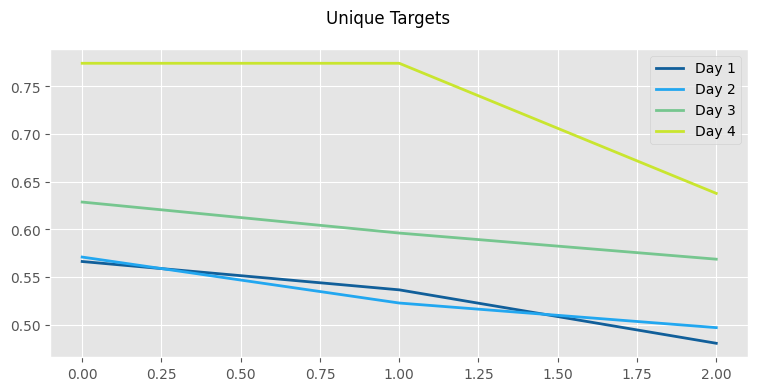

In [162]:
plot_indicator(tpv_stacked[1], indicator_titles[0], 0, day_colors)

#### Likelihood of self voting

While self-voting is penalized, agents may have learned to use it more in the accuastion rounds to indicate trust in themselves. It does go down and then back up

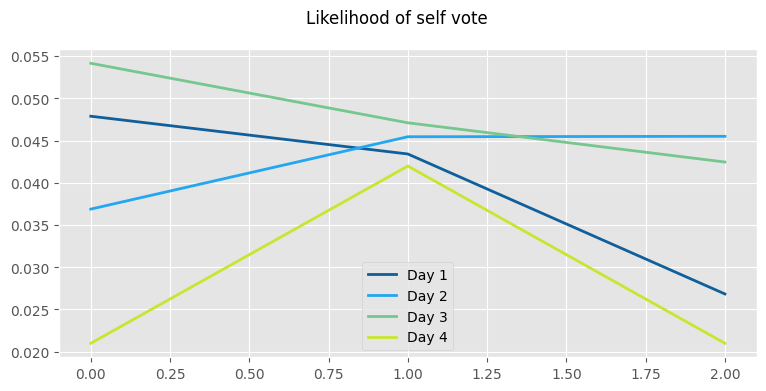

In [154]:
plot_indicator(tpv_stacked[1], indicator_titles[1], 1, day_colors)

#### Percetange of targets towards wolves

A pretty straightforward indicator where the higher the number, the more consensus and better off the villagers are. Because this number increases across phases, we can again intuit some form of consensus between actual villagers. In the last day, we see that

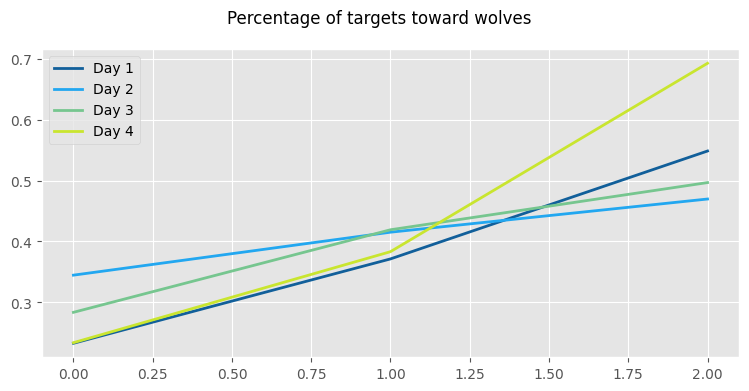

In [155]:
plot_indicator(tpv_stacked[1], indicator_titles[2], 2, day_colors)

#### Percentage of targets towards dead players

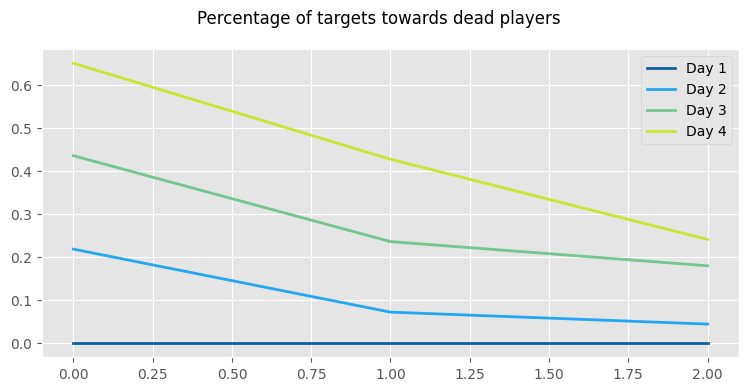

In [156]:
plot_indicator(tpv_stacked[1], indicator_titles[3], 3, day_colors)

#### Percentage of targets towards dead wolves

Indicator closely related to the one tracking _percetange of targets towards wolves_, because wheras we want wolves taregtted more, we want dead wolves targetted less as the day goes on. This is indeed what occured, throughout the phases and days.

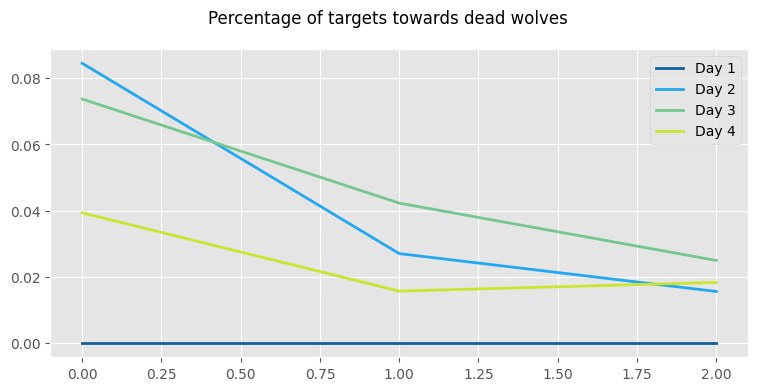

In [157]:
plot_indicator(tpv_stacked[1], indicator_titles[4], 4, day_colors)

## Additional Content


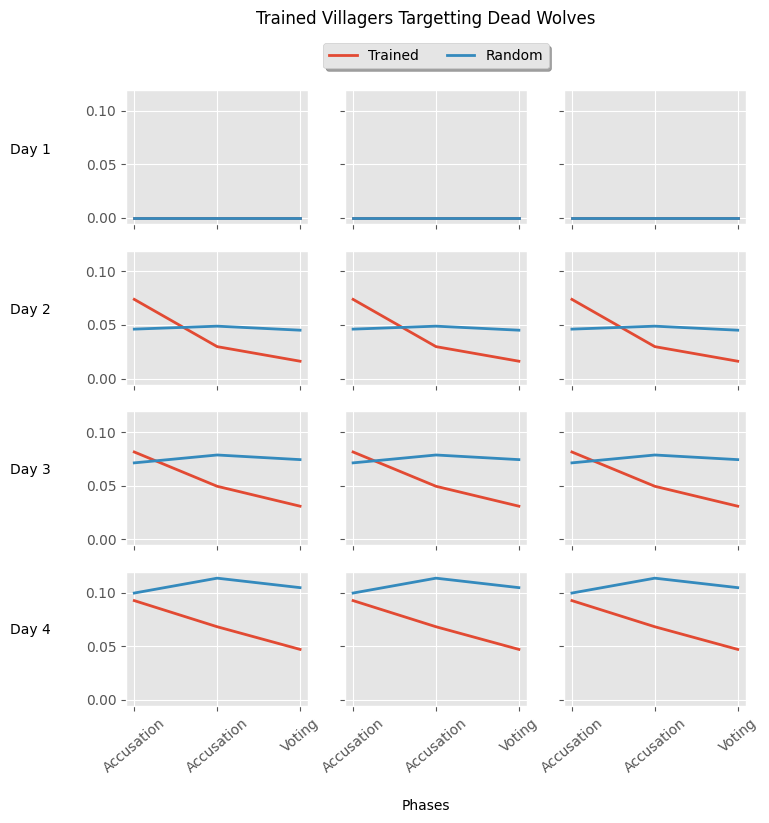

In [122]:
plt.style.use('ggplot')

# make data
x = [1,2,3]
#y = tpv_stacked[:,:,0][3]

# plot
fig, axs = plt.subplots(4, 3, figsize=(8,8), sharex=True, sharey=True)

for day in range(tpv_stacked[0].shape[0]):
    for phase in range(tpv_stacked[0].shape[1]):
        axs[day][phase].plot(list(range(tpv_stacked[0].shape[1])), tpv_stacked[0][:,:,4][day], linewidth=2.0, label="Trained")
        axs[day][phase].plot(list(range(rv_stacked[0].shape[1])), rv_stacked[0][:,:,4][day], linewidth=2.0, label="Random")

# set 
x_tick_labels = ["Accusation", "Accusation", "Voting"]
for i in [0,1,2]:
    axs[3][i].set_xticks([0,1,2], x_tick_labels, rotation=40)

axs[0][1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.40),
          ncol=3, fancybox=True, shadow=True)

fig.suptitle("Trained Villagers Targetting Dead Wolves")

fig.text(0.5, -0.02, 'Phases', ha='center')
# fig.text(0.04, 0.5, 'Days', va='center', rotation='vertical')

fig.text(-0.02, 0.80, 'Day 1')
fig.text(-0.02, 0.60, 'Day 2')
fig.text(-0.02, 0.40, 'Day 3')
fig.text(-0.02, 0.20, 'Day 4')
plt.show()

# plt.show()

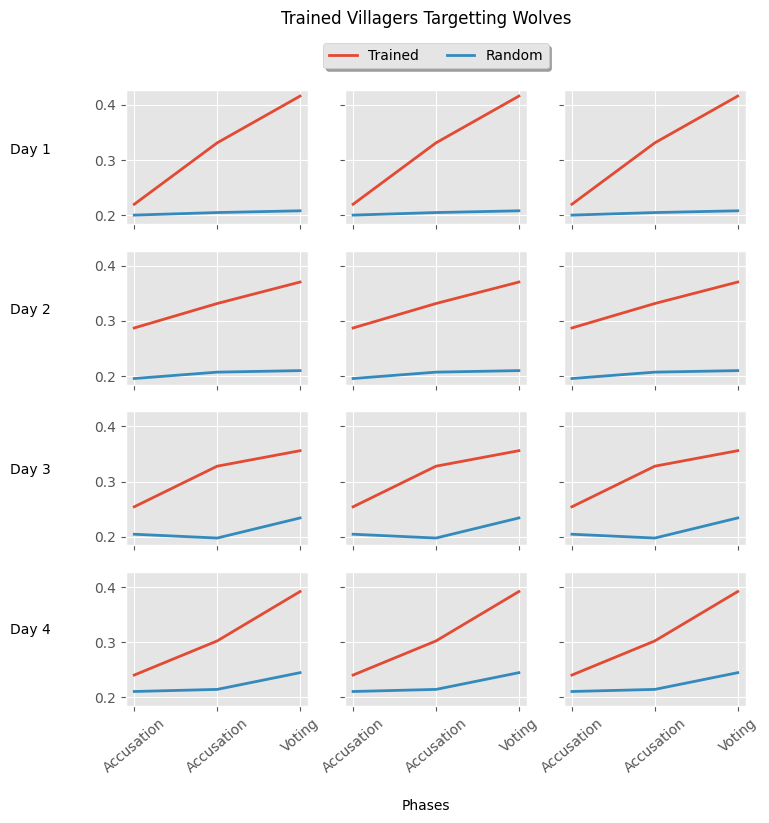

In [121]:
plt.style.use('ggplot')

# make data
x = [1,2,3]
#y = tpv_stacked[:,:,0][3]

# plot
fig, axs = plt.subplots(4, 3, figsize=(8,8), sharex=True, sharey=True)

for day in range(tpv_stacked[0].shape[0]):
    for phase in range(tpv_stacked[0].shape[1]):
        axs[day][phase].plot(list(range(tpv_stacked[0].shape[1])), tpv_stacked[0][:,:,2][day], linewidth=2.0, label="Trained")
        axs[day][phase].plot(list(range(rv_stacked[0].shape[1])), rv_stacked[0][:,:,2][day], linewidth=2.0, label="Random")

# set 
x_tick_labels = ["Accusation", "Accusation", "Voting"]
for i in [0,1,2]:
    axs[3][i].set_xticks([0,1,2], x_tick_labels, rotation=40)

axs[0][1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.40),
          ncol=3, fancybox=True, shadow=True)

fig.suptitle("Trained Villagers Targetting Wolves")

fig.text(0.5, -0.02, 'Phases', ha='center')
# fig.text(0.04, 0.5, 'Days', va='center', rotation='vertical')

fig.text(-0.02, 0.80, 'Day 1')
fig.text(-0.02, 0.60, 'Day 2')
fig.text(-0.02, 0.40, 'Day 3')
fig.text(-0.02, 0.20, 'Day 4')


plt.show()

In [125]:
len(tpv_stacked)

4

Text(-0.02, 0.2, 'Day 4')

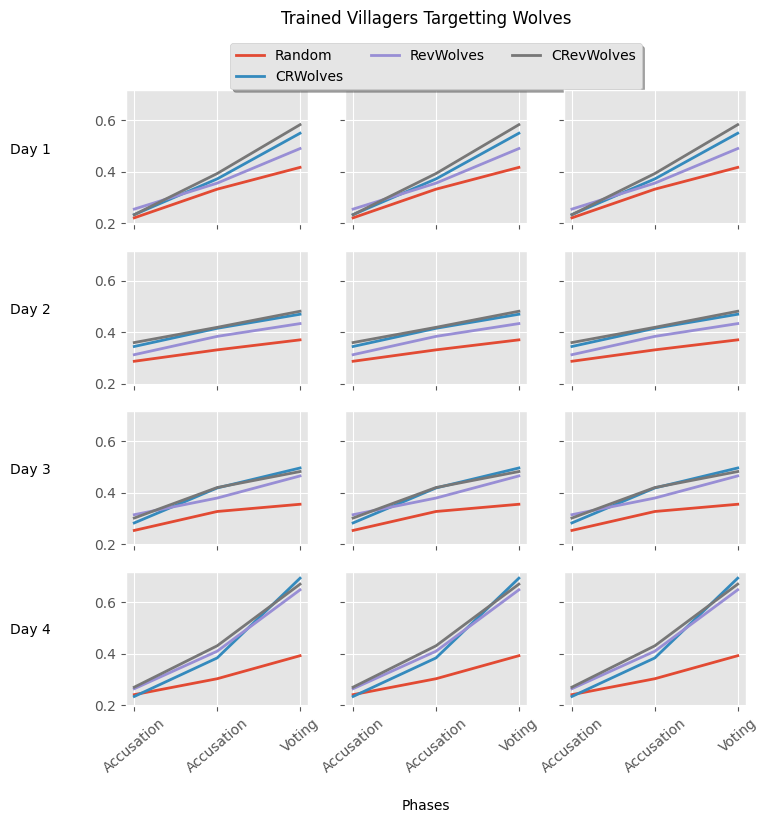

In [126]:
plt.style.use('ggplot')

# make data
x = [1,2,3]
#y = tpv_stacked[:,:,0][3]

# plot
fig, axs = plt.subplots(4, 3, figsize=(8,8), sharex=True, sharey=True)

for day in range(tpv_stacked[0].shape[0]):
    for phase in range(tpv_stacked[0].shape[1]):
        for name, stacked in zip(["Random", "CRWolves", "RevWolves", "CRevWolves"], tpv_stacked):
            axs[day][phase].plot(list(range(stacked.shape[1])), stacked[:,:,2][day], linewidth=2.0, label=name)

# set 
x_tick_labels = ["Accusation", "Accusation", "Voting"]
for i in [0,1,2]:
    axs[3][i].set_xticks([0,1,2], x_tick_labels, rotation=40)

axs[0][1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.40),
          ncol=3, fancybox=True, shadow=True)

fig.suptitle("Trained Villagers Targetting Wolves")

fig.text(0.5, -0.02, 'Phases', ha='center')
# fig.text(0.04, 0.5, 'Days', va='center', rotation='vertical')

fig.text(-0.02, 0.80, 'Day 1')
fig.text(-0.02, 0.60, 'Day 2')
fig.text(-0.02, 0.40, 'Day 3')
fig.text(-0.02, 0.20, 'Day 4')

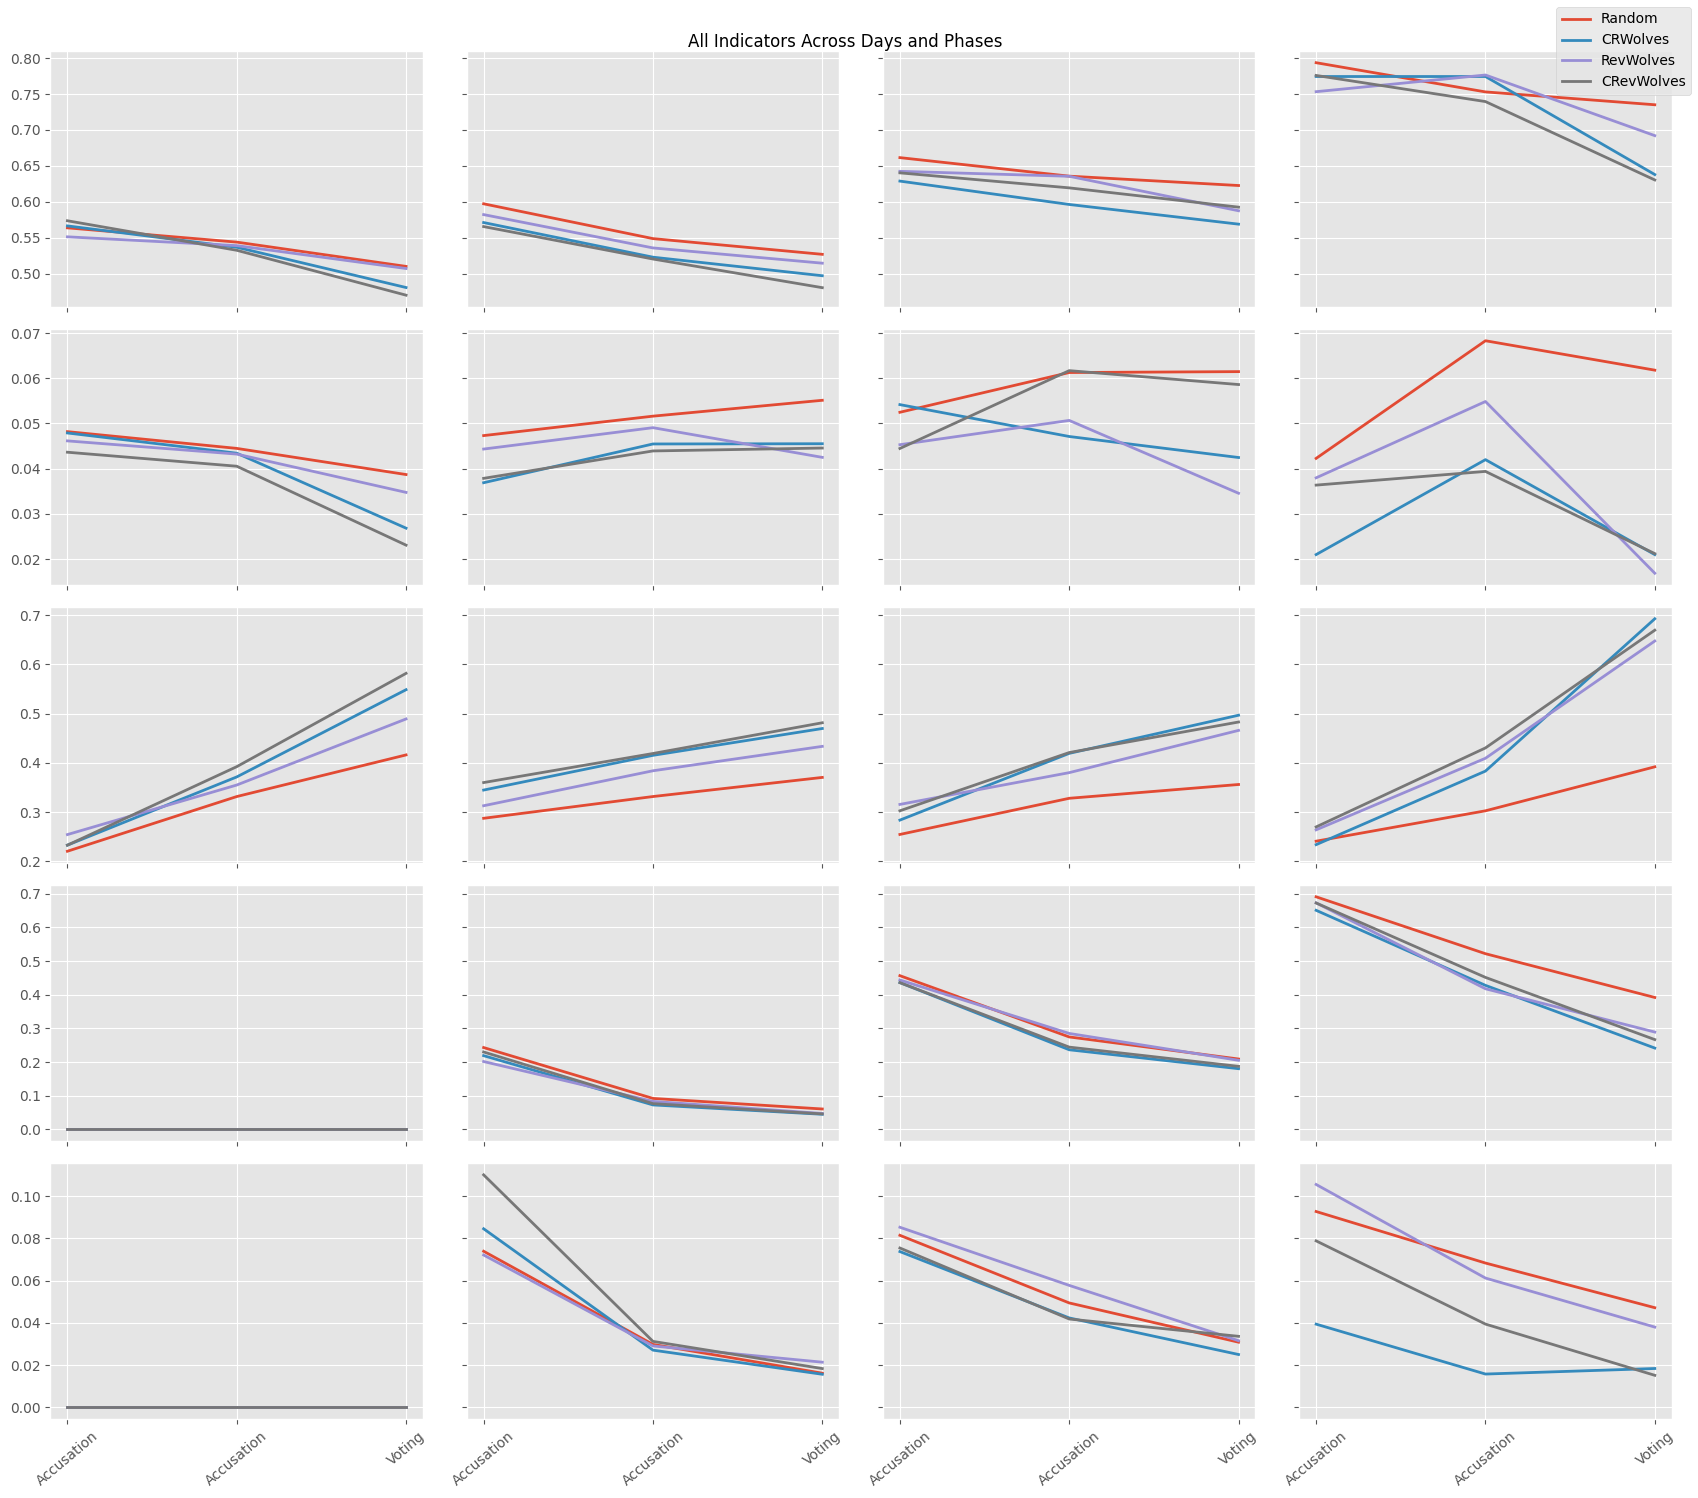

In [127]:
fig, axs = plt.subplots(tpv_stacked[0].shape[-1], 4, sharex=True, sharey='row', figsize=(17,15))

for indicator in range(tpv_stacked[0].shape[-1]):
    for day in range(tpv_stacked[0].shape[0]):
        for name, stacked in zip(["Random", "CRWolves", "RevWolves", "CRevWolves", "CRLWolves", "AggroWolves"], tpv_stacked):
            axs[indicator][day].plot(list(range(stacked.shape[1])), stacked[:,:,indicator][day], linewidth=2.0, label=name)

x_tick_labels = ["Accusation", "Accusation", "Voting"]
for i in range(4):
    axs[-1][i].set_xticks([0,1,2], x_tick_labels, rotation=40)

# lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes[-1]]
# lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.suptitle("All Indicators Across Days and Phases")
fig.legend(["Random", "CRWolves", "RevWolves", "CRevWolves"], loc="upper right")
fig.tight_layout()